# **Euler–Maruyama method**

기초적인 SDE solution  
${\displaystyle \,Y_{n+1}=Y_{n}+a(Y_{n},\tau _{n})\,\Delta t+b(Y_{n},\tau _{n})\,\Delta W_{n},}$

# ***The "FRKI" method (first-order Runge-Kutta method involving the Ito coefficient).***

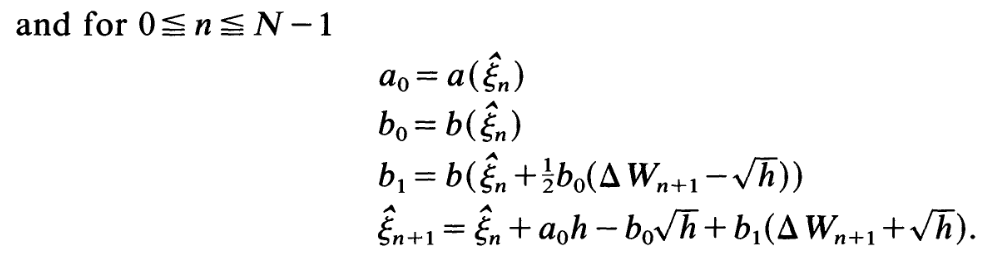


b텀에 해당되는 노이즈의 세기가 $\xi$에 영향을 주지 않는 경우 노의즈에 해당되는 텀은 사라지고 RKHG 방법으로 변하게 된다.

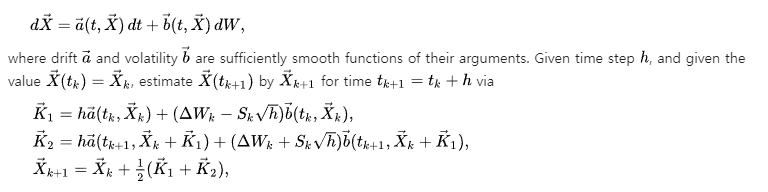  
[Runge–Kutta method (SDE)](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_(SDE))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm.notebook import tqdm

In [114]:

@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y


def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

In [115]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc




In [116]:
@jit(nopython=True)
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

# @jit(nopython=True)
def Kuramoto_mf(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0)
    Theta[:N] = dtheta
    return Theta

@jit(nopython=True)
def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta



In [112]:
N = 1000

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

  0%|          | 0/50 [00:00<?, ?it/s]

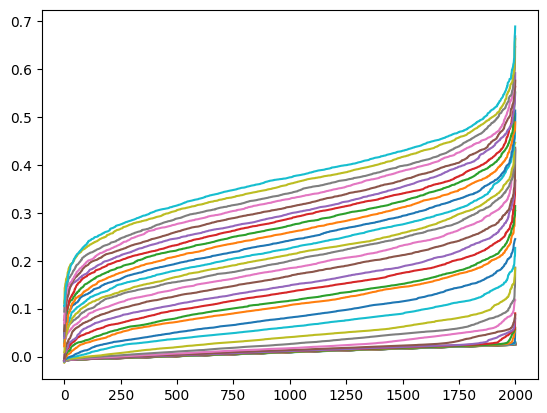

In [594]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
# D = 0.5
b = 1.10
Ds =np.linspace(0.0,1.0,50)
chis = []
d_rsigma = []
dtheta_s = []
for D in tqdm(Ds):
    # sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
    # sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
    sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
    # sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
    th = 0
    theta_s = sol[th:,:N]
    rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
    # rabs = rabs_[len(t)//2:]
    r = np.abs(rabs)
    r_mean = np.mean(r[-len(r)//2:])
    sigma_phi = np.mean(rabs[-len(r)//2:])
    sigma = np.abs(sigma_phi)
    psi = np.abs(sigma_phi)
    chi = np.mean(np.abs(rabs-sigma_phi)**2)*N
    chis.append(chi)
    d_rsigma.append(np.abs(r_mean-sigma))
    dtheta = (sol[-1] - sol[0])/(t[-1]-t[0])
    dtheta = np.sort(dtheta)
    dtheta_s.append(dtheta)
    plt.plot(dtheta)


In [595]:
np.mean(dtheta_s,axis=1)

array([0.00892263, 0.00893818, 0.00893989, 0.0089229 , 0.00897173,
       0.00896968, 0.00893081, 0.00898519, 0.00890066, 0.00882759,
       0.00915155, 0.00903679, 0.00900283, 0.00915349, 0.00920079,
       0.00912426, 0.00934544, 0.00944948, 0.00936998, 0.00958777,
       0.0098326 , 0.00984917, 0.01020463, 0.01159407, 0.01240448,
       0.0156643 , 0.02213688, 0.03088764, 0.04389401, 0.06611195,
       0.08579683, 0.11000454, 0.1187557 , 0.13652849, 0.15113725,
       0.17036324, 0.18754438, 0.20328745, 0.21431713, 0.22947938,
       0.24493866, 0.26067556, 0.27494248, 0.28901831, 0.30130954,
       0.31520441, 0.33108563, 0.34384666, 0.36153212, 0.3739643 ])

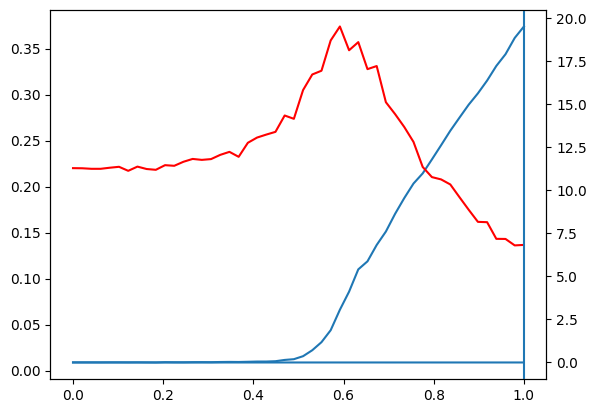

In [597]:
plt.plot(Ds, np.mean(dtheta_s,axis=1))


# plt.twinx()
plt.twinx()
plt.plot(Ds,chis,color='red')
# plt.twinx()
plt.plot(Ds,d_rsigma)
plt.axvline(D)

In [598]:
MAX_D = Ds[np.argmax(chis)]
MAX_D,np.max(chis),b

(0.5918367346938775, 19.51100625059669, 1.1)

In [619]:
(t.reshape(-1,1)*np.ones_like(sol)).shape

(10001, 2000)

In [620]:
sol.shape

(10001, 2000)

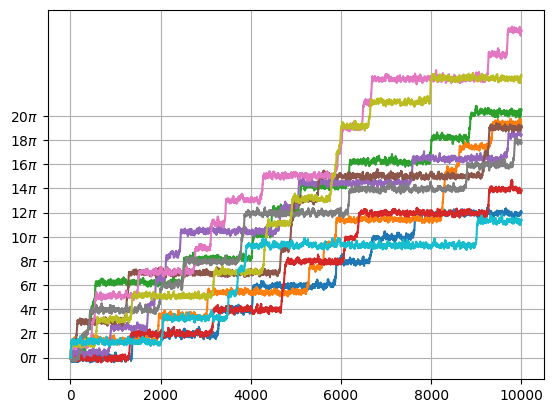

In [644]:
for i in range(10):
    plt.plot(sol.T[i]-sol.T[i][0])
plt.yticks(np.pi*np.arange(0,22,2),[r'$%d\pi$'%pi for pi in np.arange(0,22,2)])
plt.grid()

In [647]:
ro_count = sol[:]//(np.pi*2)

In [650]:
arg_sort = np.argsort(ro_count[-1])

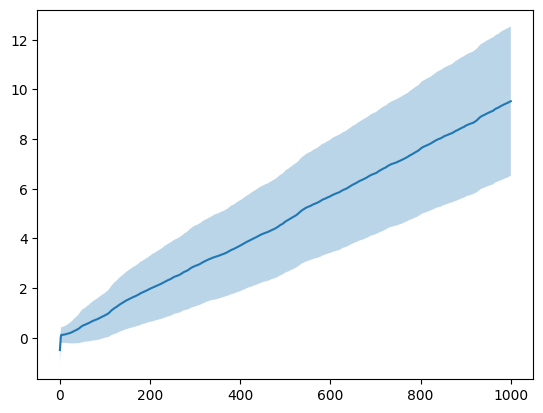

In [657]:
mean_count = np.mean(ro_count,axis=1)
std_count  = np.std(ro_count,axis=1)
plt.plot(t,mean_count)
plt.fill_between(t,mean_count-std_count,mean_count+std_count,alpha=0.3)

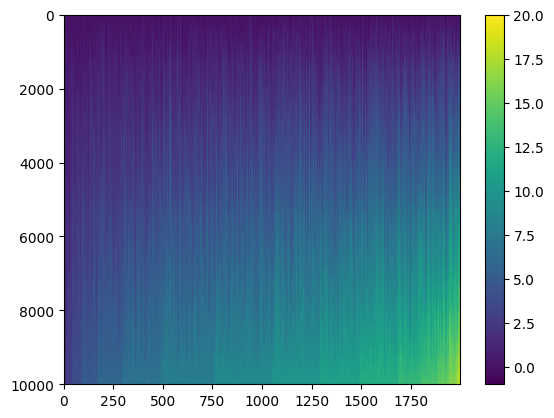

In [654]:
plt.hist2d(ro_count[:,arg_sort],)

 ...]

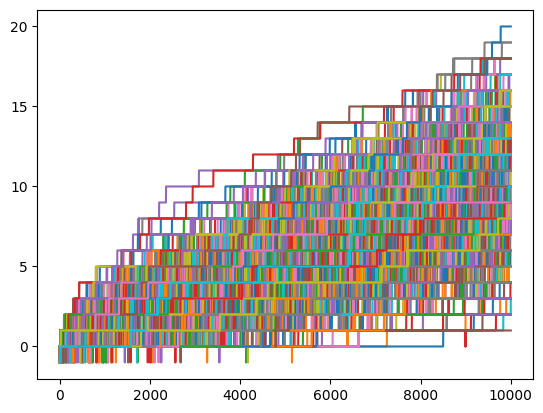

In [629]:
# plt.plot(sol.T[0] - t)
plt.plot((sol.T//(2*np.pi)).T)

## SIMUL

In [155]:
print(f'D={D}')
print(f'b={b}')

D=1.3
b=0.2


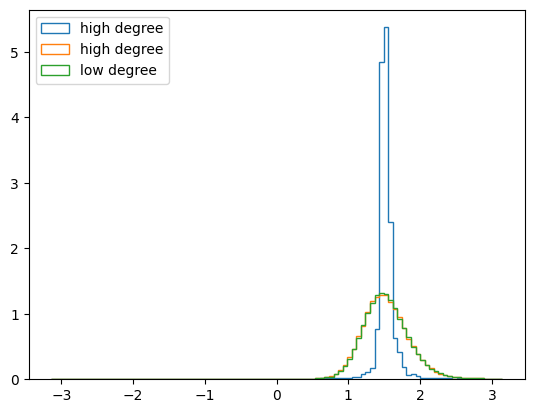

In [276]:
K = 1
t_end = 500
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
# D = MAX_D
# D = 0.6

D=0.4
b=1.05

# Ds =np.linspace(0.4,0.7,20)
# chis = []
# d_rsigma = []
sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
th = 0
theta_s = sol[th:,:N]
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
r_mean = np.mean(r[-len(r)//2:])
sigma_phi = np.mean(rabs[-len(r)//2:])
sigma = np.abs(sigma_phi)
psi = np.angle(sigma_phi)
chi = np.mean(np.abs(rabs-sigma_phi)**2)*N



A = (sol+np.pi)%(2*np.pi) - np.pi
bins = np.linspace(-np.pi,np.pi,100)

# plt.axes(polar=True)
plt.hist(np.angle(rabs[len(r)//2:]),bins=bins, histtype='step', stacked=True, fill=False,label='high degree',density=True)

plt.hist(A[len(A)//2:,:50].flatten(),bins=bins, histtype='step', stacked=True, fill=False,label='high degree',density=True)
plt.hist(A[len(A)//2:,-50:].flatten(),bins=bins, histtype='step', stacked=True, fill=False,label='low degree',density=True)
plt.legend()

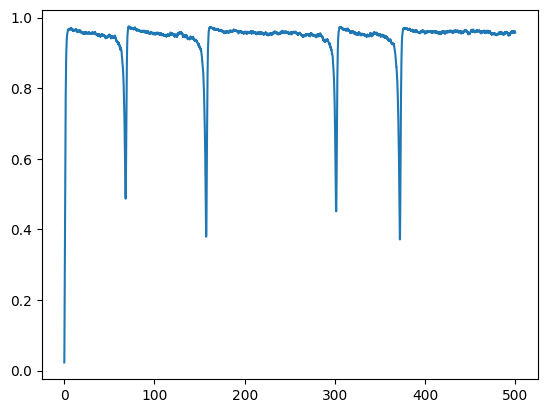

In [271]:
plt.plot(t,r)

(0.0, 6.283185307179586)

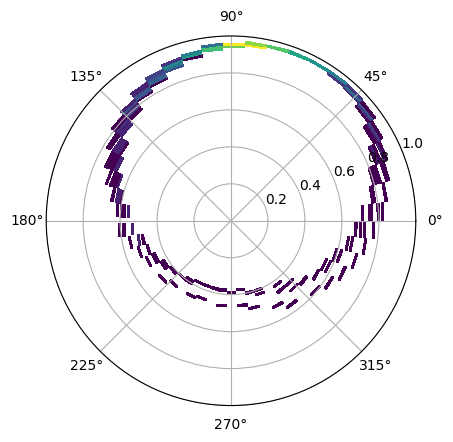

In [275]:
plt.axes(polar=True)
plt.hist2d(np.angle(rabs)[1000:],np.abs(rabs)[1000:],bins=[50,50],density=True,norm='log');
# plt.colorbar()
plt.ylim(0,1)
plt.xlim(0,2*np.pi)

In [259]:
Angle = np.angle(np.exp(1j*theta_s))
dtheta_s = np.diff(theta_s,axis=0)*dt

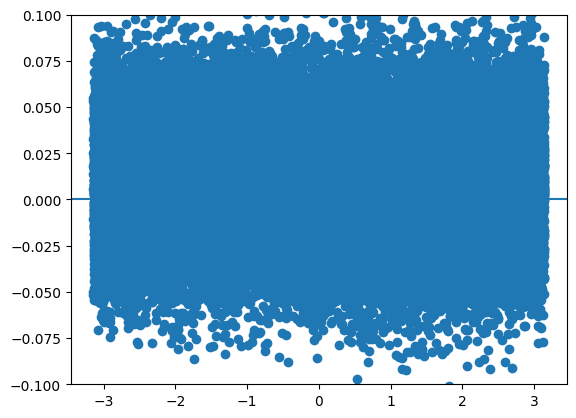

In [260]:
plt.scatter(Angle[1:,:10],dtheta_s[:,:10])
plt.ylim(-0.1,0.1)
plt.axhline(0)

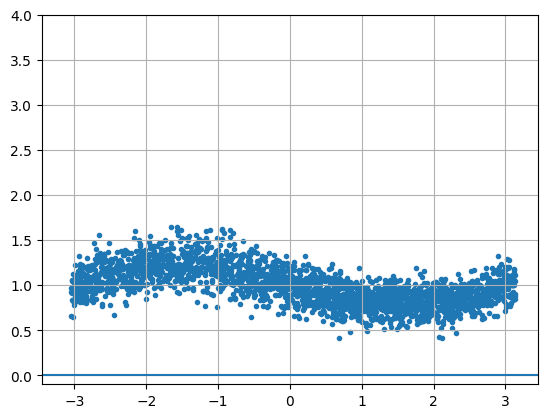

In [261]:
psis = np.angle(rabs[len(r)//2:])

plt.scatter(psis[1:],np.diff(psis)/dt,marker='.')
plt.ylim(-0.1,4)
plt.axhline(0)
plt.grid()


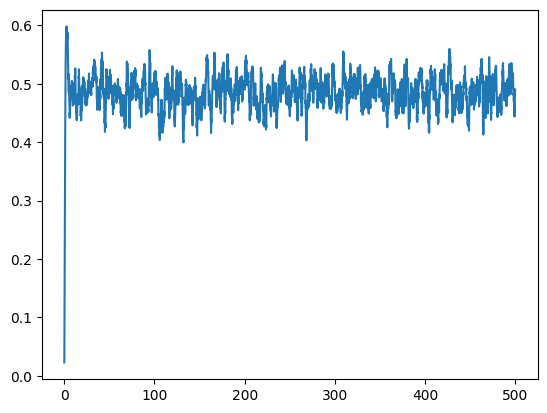

In [237]:
plt.plot(t,r)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 1.400e+01, 4.977e+03]),
 array([-2.98038891, -2.55039388, -2.12039885, -1.69040381, -1.26040878,
        -0.83041375, -0.40041872,  0.02957632,  0.45957135,  0.88956638,
         1.31956142]),
 <BarContainer object of 10 artists>)

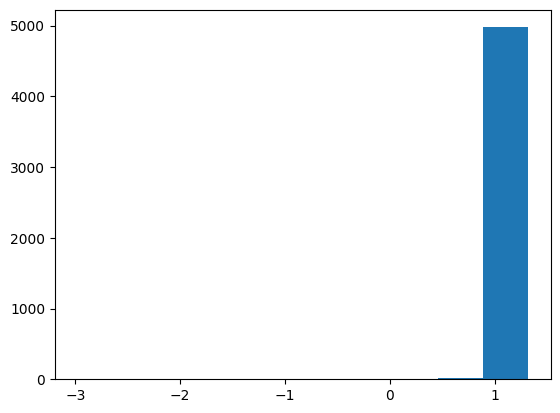

In [238]:
plt.hist(np.angle(rabs))


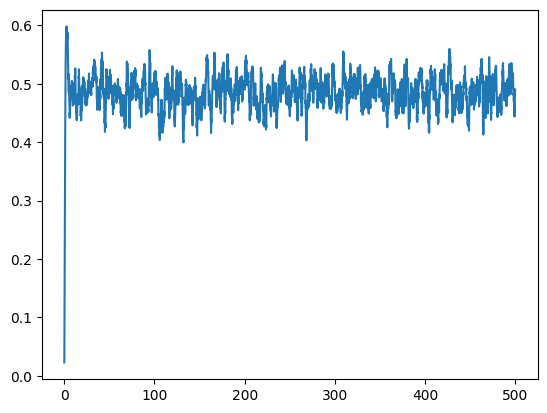

In [239]:
plt.plot(t,r)

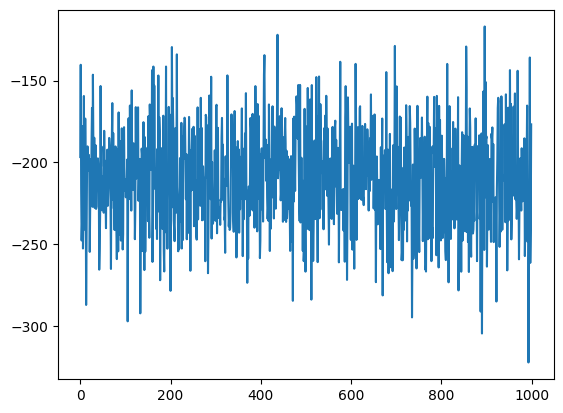

In [240]:
plt.plot(sol[-1] - t[-1]*omega)

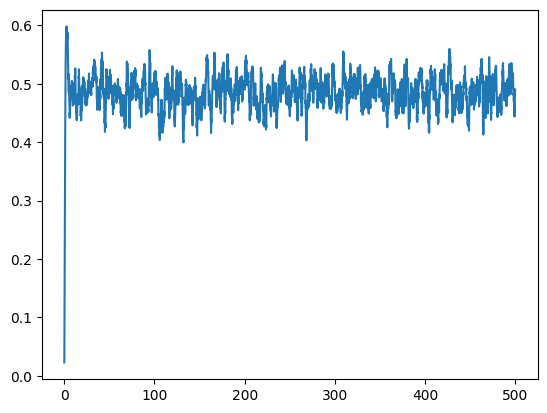

In [241]:
plt.plot(t,r)

In [213]:
M = np.mean(np.exp(1j*sol),axis=1)
Mm = np.mean(M[len(M)//2:])
chi = np.mean(np.abs(M-Mm)**2)*N

In [214]:
plt.plot(Ds,chis,color='red')
plt.twinx()
plt.plot(Ds,d_rsigma)
plt.axvline(D)

NameError: name 'Ds' is not defined

In [215]:
real = np.linspace(-1,1,30)

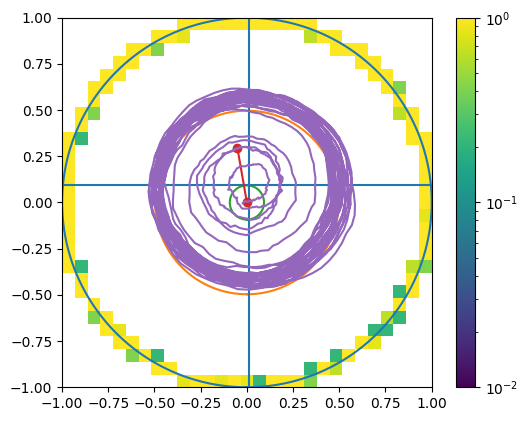

In [268]:
exps =np.exp(1j*theta_s)

idx = 100
plt.figure()
ax = plt.gca()
fig = plt.gcf()


hist_2d = ax.hist2d(np.real(exps[idx]),np.imag(exps[idx]),bins=[real,real],norm='log',density=True,vmax=1,vmin=1e-2)
plt.gca().set_aspect('1')
plt.colorbar(hist_2d[-1])

c_ = np.linspace(-np.pi,np.pi,10000)
ax.plot(np.sin(c_),np.cos(c_))
ax.plot(r_mean*np.sin(c_),r_mean*np.cos(c_))
ax.plot(sigma*np.sin(c_),sigma*np.cos(c_))
ax.axvline(np.real(sigma_phi))
ax.axhline(np.imag(sigma_phi))

ax.plot([0,np.real(rabs)[idx]],[0,np.imag(rabs)[idx]],'o-')
# ax.axvline(np.real(rabs)[-idx],color='red')
# ax.axhline(np.imag(rabs)[-idx],color='red')
ax.plot(np.real(rabs)[:2000],np.imag(rabs)[:2000])

# plt.scatter(np.real(exps[-1]),np.imag(exps[-1]));
# np.histogram2d()

In [243]:
### ANIMATAION 관련 ###
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
from matplotlib.colors import Normalize
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [244]:
def animation(idx):
    # data_n = np.sin(sol[idx].reshape((N,N)))
    ax.clear()
    hist_2d = ax.hist2d(np.real(exps[idx]),np.imag(exps[idx]),bins=[real,real],norm='log',density=True,vmax=1,vmin=1e-2)
    ax.plot([0,np.real(rabs)[idx]],[0,np.imag(rabs)[idx]],'o-')
    
idxs=  np.arange(0,300,1)

In [219]:
ani = FuncAnimation(fig,animation,frames=idxs,interval=50)
# 확인용
HTML(ani.to_html5_video())

In [245]:
d_theta = (sol[-1] - sol[0])/(t[-1]-t[0])
d_theta = np.sort(d_theta)

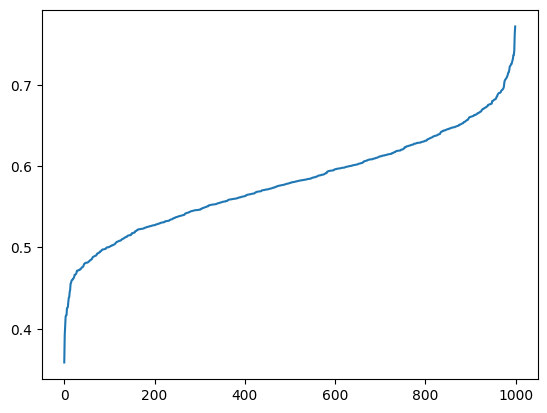

In [246]:
plt.plot(np.sort(d_theta))

In [247]:
hist_2d[-1].get_data

AttributeError: 'QuadMesh' object has no attribute 'get_data'

(-1.0, 1.0)

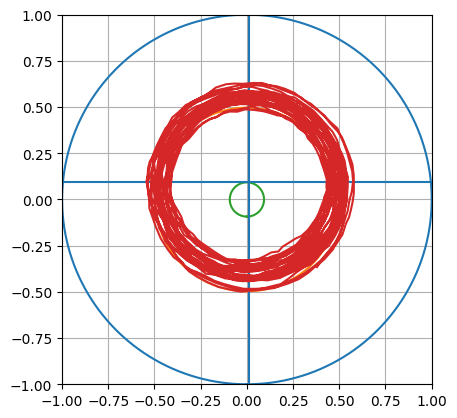

In [267]:
c_ = np.linspace(-np.pi,np.pi,10000)
plt.plot(np.sin(c_),np.cos(c_))
plt.plot(r_mean*np.sin(c_),r_mean*np.cos(c_))
plt.plot(sigma*np.sin(c_),sigma*np.cos(c_))
plt.axvline(np.real(sigma_phi))
plt.axhline(np.imag(sigma_phi))
plt.plot(np.real(rabs)[-2000:],np.imag(rabs)[-2000:])




ax = plt.gca()
ax.set_aspect(1)
plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

In [249]:
# np.abs(rabs)
np.angle(rabs)

array([-2.98038891,  0.14899182,  0.27627657, ...,  1.0970927 ,
        1.11068908,  1.12633369])

(0.0, 1.0)

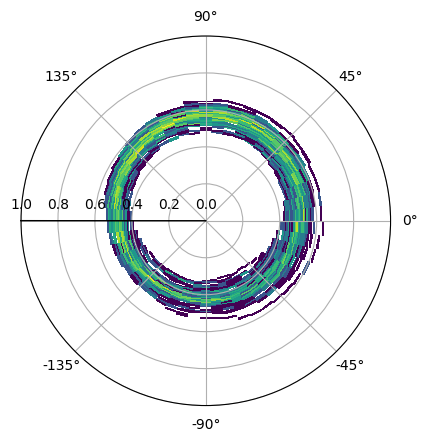

In [266]:
plt.axes(polar=True)
plt.hist2d(np.angle(rabs)[1000:],np.abs(rabs)[1000:],bins=[50,50],density=True,norm='log');
# plt.colorbar()
plt.ylim(0,1)


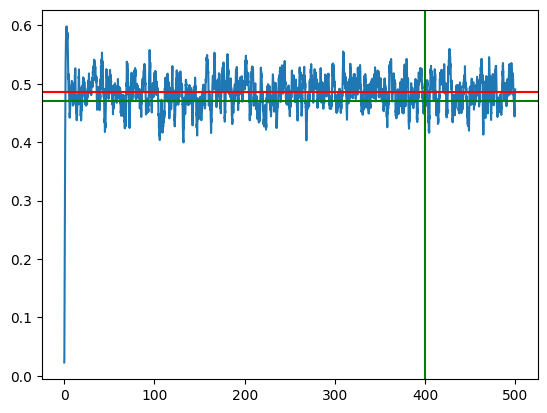

In [253]:
plt.plot(t,r)
minus = 1000
plt.axhline(r[-minus],color='green')
plt.axvline(t[-minus],color='green')

plt.axhline(r_mean,color='orange')
plt.axhline(sigma,color='red')

In [254]:
from scipy.integrate import quad

In [225]:
def integrand(phi,omega,b):
    return 1/(omega-b*np.sin(phi))

(array([0.19900426, 0.2151234 , 0.23140164, 0.25049897, 0.26323901,
        0.27951088, 0.2972973 , 0.31112552, 0.32487102, 0.33789106,
        0.34995655, 0.35797476, 0.36863389, 0.37179026, 0.37406845,
        0.37686209, 0.376913  , 0.37620027, 0.37545573, 0.36492387,
        0.35999204, 0.35044656, 0.3426829 , 0.32952922, 0.31638827,
        0.30574187, 0.2946882 , 0.28029361, 0.26617902, 0.25266261,
        0.24020894, 0.22809254, 0.21642795, 0.201467  , 0.19132969,
        0.1801742 , 0.17108054, 0.16233687, 0.15277866, 0.14252681,
        0.1347377 , 0.12808131, 0.11845946, 0.11285945, 0.10681397,
        0.09906304, 0.09403575, 0.09017937, 0.08537481, 0.08106025,
        0.07775115, 0.07363387, 0.07183932, 0.06734021, 0.06552657,
        0.06267565, 0.05928382, 0.05964019, 0.05650927, 0.05467654,
        0.05234744, 0.05124652, 0.05019016, 0.04944561, 0.04905743,
        0.0479947 , 0.04605378, 0.0465056 , 0.04464105, 0.04527742,
        0.0445265 , 0.0444565 , 0.04435468, 0.04

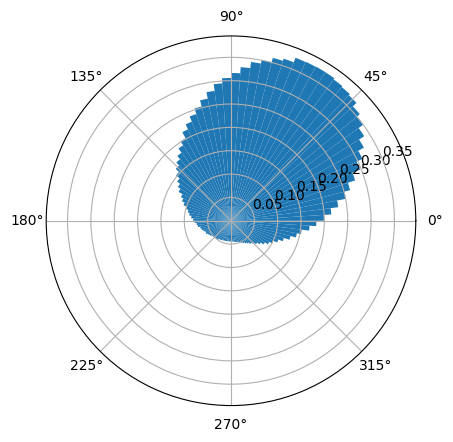

In [255]:
plt.axes(polar=True)
plt.hist(sol[len(sol)//2:].flatten()%(2*np.pi),bins=100,density=True)

In [22]:
quad(integrand,-np.pi,np.pi,args=(1,b))

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_22349/1618518308.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(integrand,-np.pi,np.pi,args=(1,b))


(138.79066070260393, 293.3148099134884)

In [17]:
rtheta_s = np.l

AttributeError: module 'numpy' has no attribute 'l'

In [ ]:
dtheta_s = omega - b*np.sin(theta_s) - K/mk *

In [251]:
db = 0.02
Ds = np.arange(0,2+db/2,db)
bs = np.arange(0,2+db/2,db)
len(Ds)
# Ds = np.linspace(0,2,10)
# bs = np.linspace(0,2,11)

101

In [252]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for b in bs:        
        sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
        theta_s = sol[th:,:N]
        dtheta_s = sol[th:,N:2*N] 
        rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
        # rabs = rabs_[len(t)//2:]
        r = np.abs(rabs)
        sigma_phi = np.mean(rabs)
        sigma = np.abs(sigma_phi)
        psi = np.abs(sigma_phi)
        sigma,np.mean(r)
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/101 [00:00<?, ?it/s]

In [253]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)
D_r_meanij = np.mean(D_rij,axis=2)

In [254]:
np.savez(f'db={db}',Ds=Ds,bs=bs,D_rij =D_rij,D_mrij=D_r_meanij,D_sij = D_sigmaij)

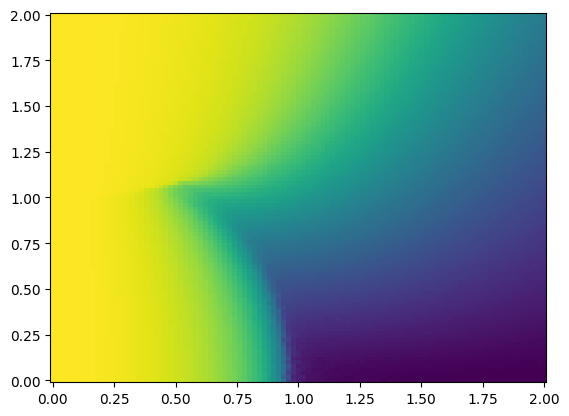

In [255]:
plt.pcolormesh(Ds,bs,D_r_meanij.T)

In [256]:
DD,BB = np.meshgrid(Ds,bs)

In [ ]:
Z = np.abs(D_sigmaij-D_r_meanij).T
# CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

CS  = plt.pcolormesh(Ds,bs,abs(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


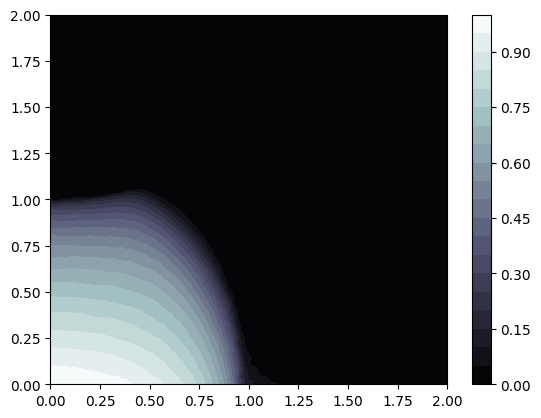

In [320]:
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

# CS  = plt.pcolormesh(Ds,bs,(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


In [259]:
theta_s = sol[:,:N]
dtheta_s = sol[:,N:2*N] 
rabs_ = np.mean(np.exp(theta_s.T*1j),axis=0)
rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)
sigma,np.mean(r)

(0.4288721064156325, 0.42948551530501594)

In [260]:
D_r_meanij = np.mean(D_rij,axis=2)

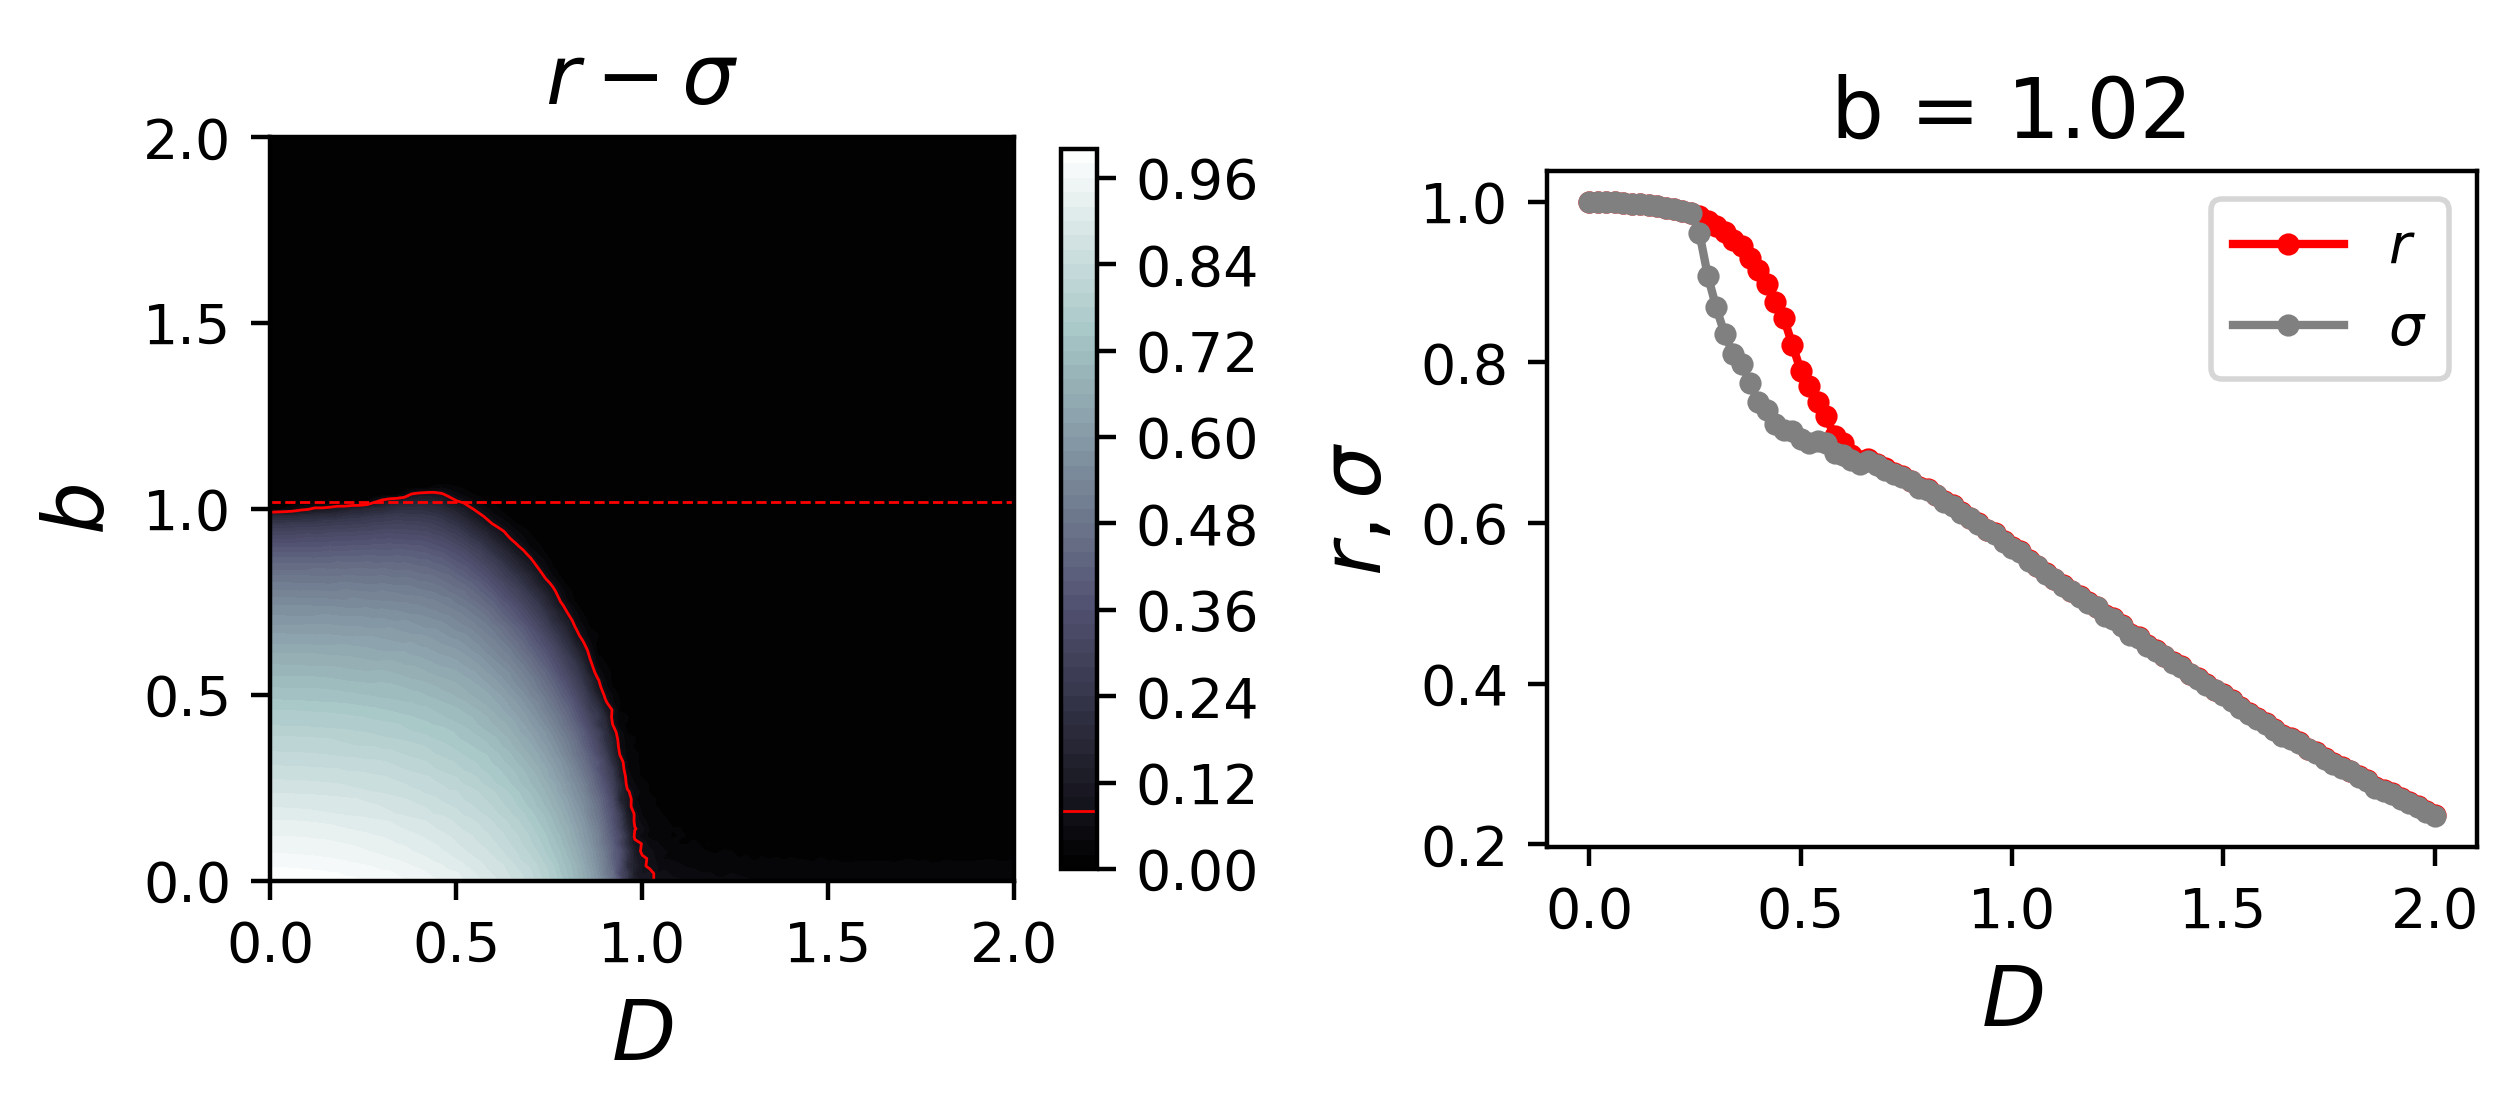

In [391]:
fig,(ax1,ax2) = plt.subplots(1,2,width_ratios=[1,1],dpi=400)
plt.sca(ax1)
b_idx = 51
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,50, cmap=plt.cm.bone)

CS2 = plt.contour(CS, levels=CS.levels[4:5],linewidths=0.5, colors='r')
cbar = plt.colorbar(CS,shrink=0.4)
plt.gca().set_aspect('1')
cbar.add_lines(CS2)
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$b$',fontsize=15)
plt.title(r'$r-\sigma$',fontsize=15)

plt.axhline(bs[b_idx],color='red',lw=0.5,ls='--')

plt.sca(ax2)

plt.plot(Ds,D_r_meanij[:,b_idx],'.-',color='red',label =r'$r$')
plt.plot(Ds,D_sigmaij[:,b_idx],'.-',color='gray',label =r'$\sigma$')
plt.gca().set_aspect('1.9')

plt.legend()
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title(f'b = {bs[b_idx]}',fontsize=15)

plt.tight_layout()
plt.show()

In [407]:
vphase = theta_s.T - t

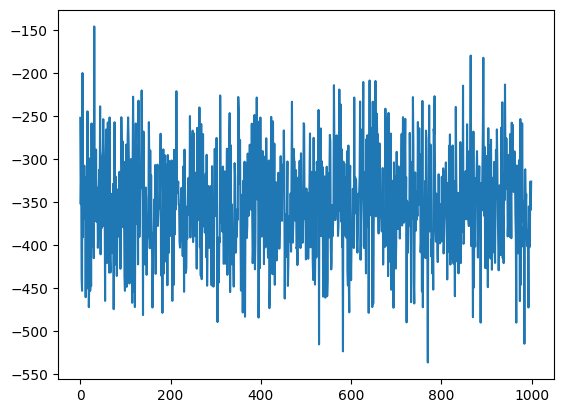

In [411]:
plt.plot(vphase[:,-1])

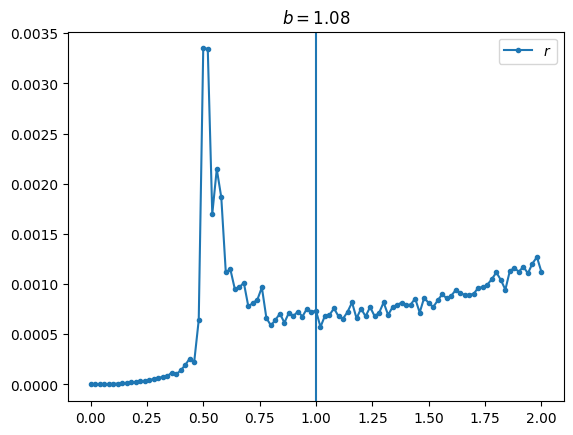

In [319]:
b_idx = 54
plt.plot(Ds,D_r_meanij[:,b_idx]-D_sigmaij[:,b_idx],'.-',label =r'$r$')
plt.title(rf'$b={bs[b_idx]}$')
# plt.plot(Ds,D_sigmaij[:,b_idx],'d-',color='gray',label =r'$\sigma$')
# plt.axhline(3/np.sqrt(N))
plt.axvline(1)
plt.legend()
# plt.plot(D_rij[:,5,-1])

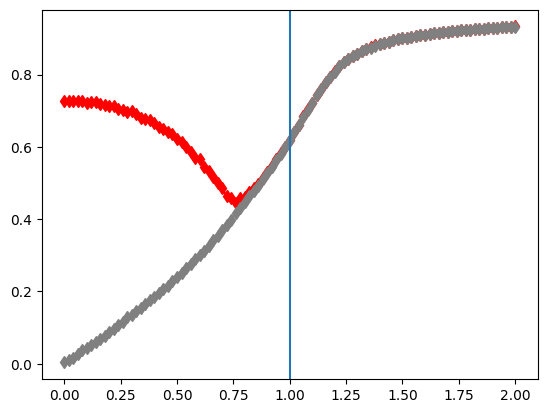

In [303]:
D_idx= 40
plt.plot(bs,D_r_meanij[D_idx,:],'d-',color='red')
plt.plot(bs,D_sigmaij[D_idx,:],'d-',color='gray')
plt.xlabel(r'$b$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title('b')
# plt.axhline(3/np.sqrt(N))
plt.axvline(1)
# plt.plot(D_rij[:,5,-1])

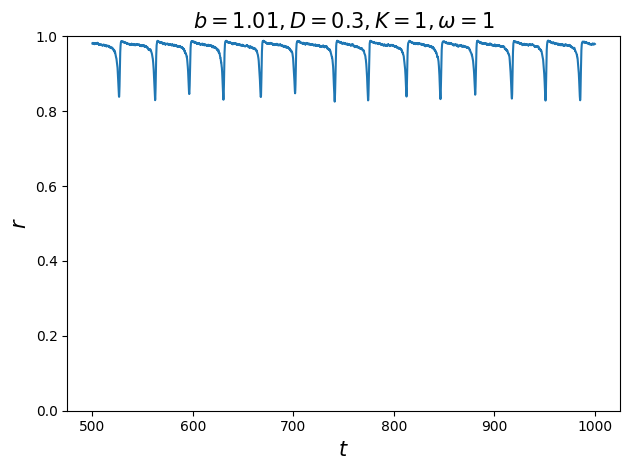

In [190]:
plt.plot(t[len(t)//2:],r)
plt.xlabel('$t$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.title(rf'$b={b},D={D},K={K},\omega=1$',fontsize=15)
plt.ylim(0.0,1)
plt.tight_layout()

In [191]:
h,b_ = np.histogram(np.sin(theta_s[len(t)//2,:]),bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(np.sin(theta_s[len(t)//2+i,:]),bins=b_)
    hs.append(h)
hs = np.array(hs)
h

array([ 4,  8,  5,  5,  3,  7,  6,  6,  6,  1,  7,  8,  6,  5,  5,  6, 11,
        7,  9,  4,  5,  4,  5,  2,  5,  4,  6,  6,  5,  7,  6,  5,  8,  8,
        7,  7, 12,  7,  5,  7,  7,  5, 10,  7,  4, 10,  6, 13,  6,  9,  7,
        7,  6, 10,  8,  7,  3,  9,  7,  9,  8,  9,  6,  7,  8,  5,  8,  9,
        5,  9,  8, 10, 10,  6,  5,  3,  5,  4, 10,  9,  8,  6,  4,  2,  4,
        5,  6,  3,  7, 10,  4,  7,  5,  3,  1,  2,  6,  1,  5,  6])

In [192]:
dtheta_s = np.diff(theta_s/dt,axis=0)

In [193]:
dtheta_s = np.diff(theta_s,axis=1)
sum_time = 10
dtheta_c = np.cumsum(dtheta_s[:], axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
diff_avg_dtheta = np.diff(avg_dtheta, axis=1)

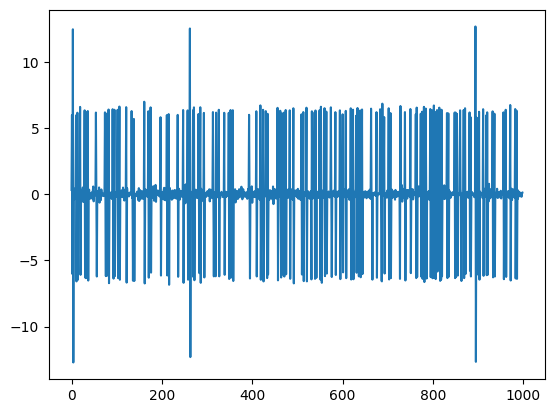

In [194]:
plt.plot(avg_dtheta[-1])

In [195]:
np.mean(avg_dtheta[-1])

0.0001789671814094307

In [196]:
avg_dtheta.shape

(9991, 999)

In [197]:
b_theta = np.arcsin(b_)

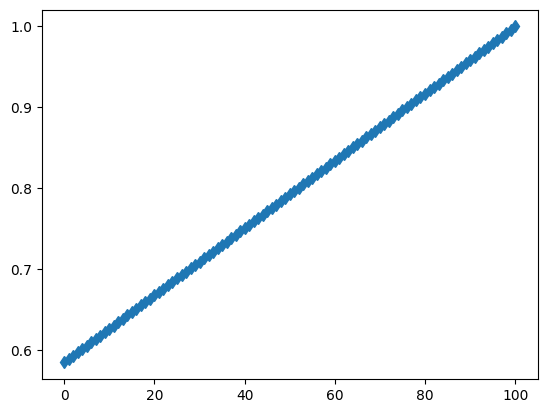

In [198]:
plt.plot(b_,'d')

In [199]:
A = (theta_s+np.pi)%(2*np.pi)-np.pi

In [200]:
h,b_ = np.histogram(np.linspace(-np.pi,np.pi),bins=200)
# h,b_ = np.histogram(A[len(t)//2,:],bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(A[len(t)//2+i,:],bins=b_)
    hs.append(h)
hs = np.array(hs)
# b_theta = np.arcsin(b_)


In [201]:
b_theta = b_

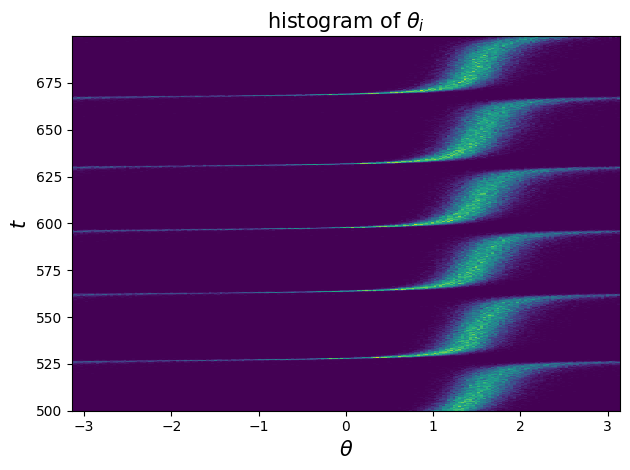

In [202]:
plt.pcolormesh(b_theta,t[len(t)//2:len(t)//2+2000],hs[1:])
plt.gca().set_aspect('auto')
plt.ylabel(r'$t$',fontsize=15)
plt.xlabel(r'$\theta$',fontsize=15)
plt.title(r'histogram of $\theta_i$',fontsize=15)
plt.xlim(-np.pi,np.pi)
plt.tight_layout()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.,   1.,   1.,   0.,   0.,   1.,   0.,   3.,   1.,   3.,   4.,
          3.,   2.,   3.,   2.,   2.,   4.,   3.,   2.,   3.,   4.,   4.,
          2.,   7.,   8.,   9.,  18.,  10.,   3.,  13.,  22.,  16.,  16.,
         20.,  19.,  24.,  21.,  27.,  19.,  29.,  27.,  32.,  27.,  24.,
         35.,  31.,  40.,  28.,  30.,  36.,  38.,  46.,  50.,  52.,  56.,
        112.]),
 array([0.9275491 , 0.92827361, 0.92899812, 0.92972262, 0.93044713,
        0.93117164, 0.93189615, 0.93262066, 0.93334517, 0.93406967,
        0.93479418, 0.93551869, 0.9362432 , 0.93696771, 0.93769222,
        0.93841672, 0.93914123, 0.93986574, 0.94059025, 0.94131476,
        0.94203927, 0.94276377, 0.94348828, 0.

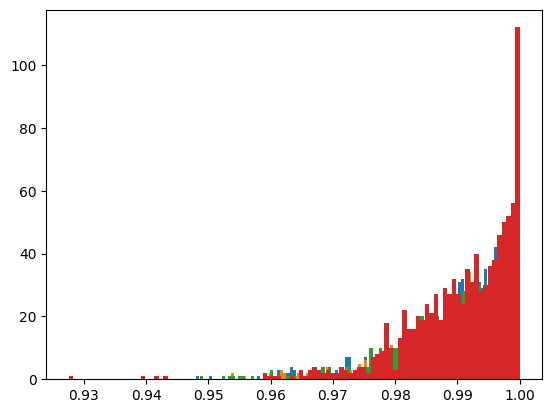

In [132]:

plt.hist(np.sin(theta_s[len(t)//2,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+10,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+20,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+30,:]),bins=100)

# phase velocity

In [1006]:
K = 1
t_end = 600
dt = 0.01
t = np.arange(0, t_end+dt/2, dt)
D = 0.1
b = 1.51
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
th = len(t)//2
theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N]
t_ = t[th:] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1007]:
theta_s[-1].shape

(1000,)

In [1008]:
v = (theta_s[-1] - theta_s[0])/(t_[-1] - t_[0])

In [1009]:
# plt.plot(v)
np.mean(v)
# plt.hist(v,bins=100)

-4.309196353852273e-05

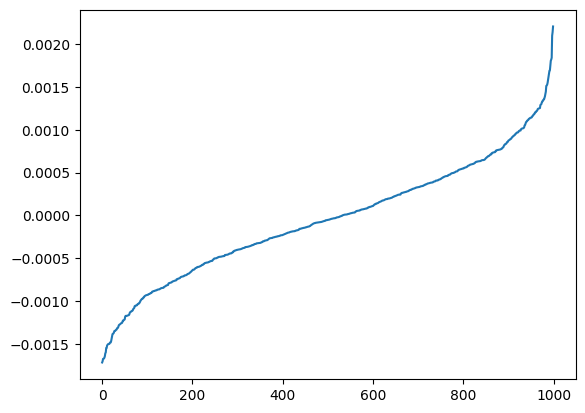

In [1010]:
# plt.hist(v,bins=100)
plt.plot(np.sort(v))

## Model network  
igraph  
networkx

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit

In [89]:
@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y

In [90]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [129]:

@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y

@jit(nopython = True)
def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta

In [92]:
# # @jit(nopython=True)
# def get_order_parameter(theta,N):
#     ''' get theta and return r and theta'''
#     rpsi = 1/N*np.sum(np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi

# # @jit(nopython=True)
# def Kuramoto_mf(Theta,t,omega,N,K):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto(Theta,t,omega,N,K,mk,Aij):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
#     Theta[:N] = dtheta
#     return Theta

# # @jit(nopython=True)
# def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta

# def get_order_parameter_ann(theta,N,mk,DEGT):
#     ''' get theta and return r and theta'''
#     rpsi = 1/(N*mk)*np.sum(DEGT*np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi



# def Kuramoto_AMF_AR(Theta,t,omega,N,K,mk,DEGT,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter_ann(theta,N,mk,DEGT)
#     dtheta = omega + K/mk*r*DEGT.flatten()*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


In [397]:
mk = 5
N = 1000
p = mk/(N)
# G = nx.erdos_renyi_graph(N,p)
G = nx.barabasi_albert_graph(N,5)

In [398]:
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
mk = Deg.mean()
mk

9.95

In [399]:
mk

9.95

In [400]:
# A = nx.adjacency_matrix(G)
Aij = A.todense()

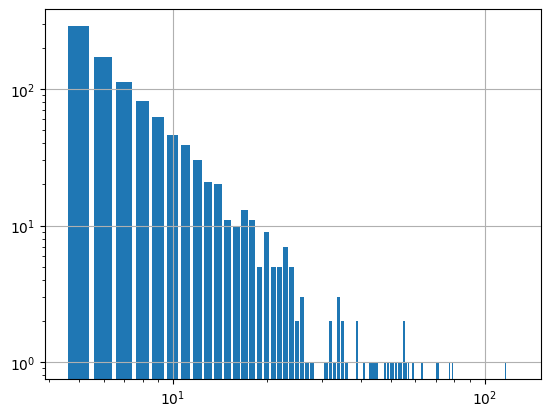

In [401]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.loglog()
plt.grid()

In [402]:
np.unique(degree_sequence, return_counts=True)

(array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  31,  32,
         33,  34,  35,  36,  39,  41,  43,  44,  45,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  59,  63,  70,  71,  77,  79, 117,
        127, 128]),
 array([291, 172, 113,  82,  62,  46,  39,  30,  21,  20,  11,  10,  13,
         11,   5,   9,   5,   5,   7,   5,   2,   3,   1,   1,   1,   2,
          1,   3,   2,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1]))

In [403]:
# N = 200

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

In [404]:
print(f'D={D}')
print(f'b={b}')

D=0.3
b=1.04


In [439]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 1.0
b = 0.5

# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
th = 0
theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
r_mean = np.mean(r[-len(r)//2:])
sigma_phi = np.mean(rabs[-len(r)//2:])
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)
chi = np.mean(np.abs(rabs-sigma_phi)**2)*N

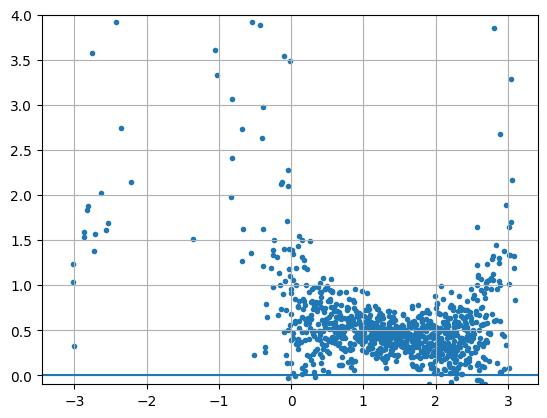

In [440]:
psis = np.angle(rabs[len(r)//2:])

plt.scatter(psis[1:],np.diff(psis)/dt,marker='.')
plt.ylim(-0.1,4)
plt.axhline(0)
plt.grid()


(0.0, 6.283185307179586)

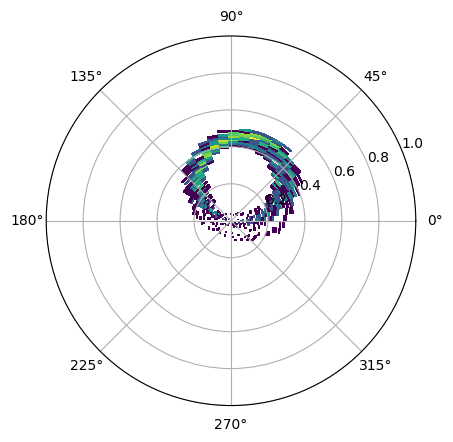

In [441]:
plt.axes(polar=True)
plt.hist2d(np.angle(rabs)[1000:],np.abs(rabs)[1000:],bins=[50,50],density=True,norm='log');
# plt.colorbar()
plt.ylim(0,1)
plt.xlim(0,2*np.pi)

(0.0, 6.283185307179586)

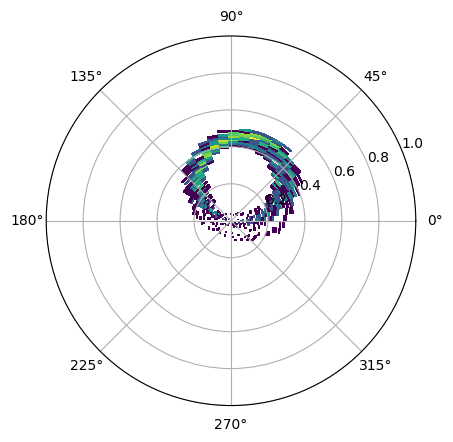

In [442]:
plt.axes(polar=True)
plt.hist2d(np.angle(rabs)[1000:],np.abs(rabs)[1000:],bins=[50,50],density=True,norm='log');
# plt.colorbar()
plt.ylim(0,1)
plt.xlim(0,2*np.pi)

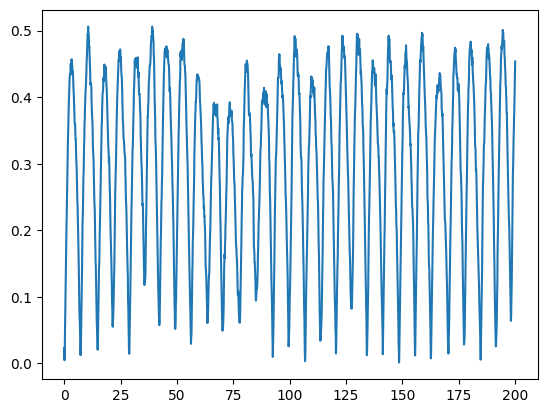

In [443]:
plt.plot(t,r)

In [444]:
ro_count = sol[:,]//(np.pi*2)

In [427]:
ro_count

array([[ 0., -1.,  0., ..., -1.,  0., -1.],
       [ 0., -1.,  0., ..., -1.,  0., -1.],
       [ 0., -1.,  0., ..., -1.,  0., -1.],
       ...,
       [30., 30., 35., ..., 31., 28., 27.],
       [30., 30., 35., ..., 30., 28., 27.],
       [30., 30., 35., ..., 31., 27., 27.]])

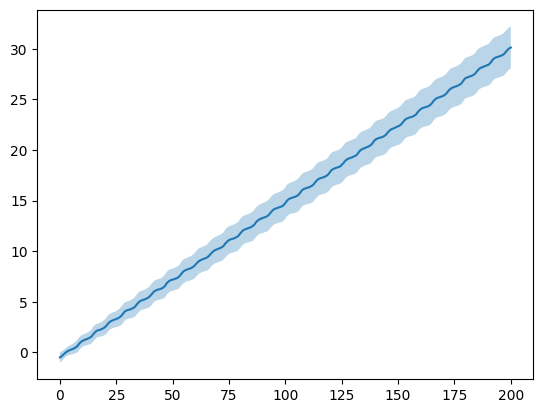

In [428]:
mean_count = np.mean(ro_count,axis=1)
std_count  = np.std(ro_count,axis=1)
plt.plot(t,mean_count)
plt.fill_between(t,mean_count-std_count,mean_count+std_count,alpha=0.3)

In [413]:
Deg = np.sum(Aij,axis=1)
Arg_Deg = np.argsort(Deg)

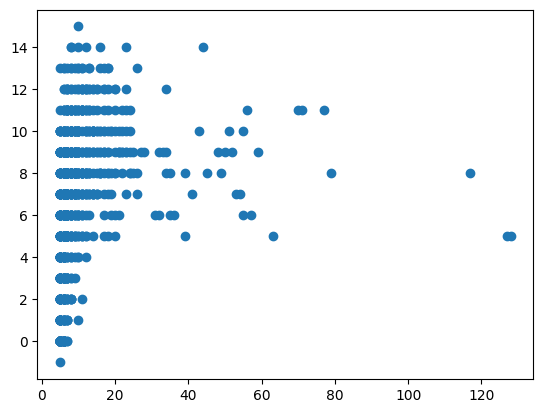

In [414]:
plt.scatter(Deg,ro_count[-1,Arg_Deg])

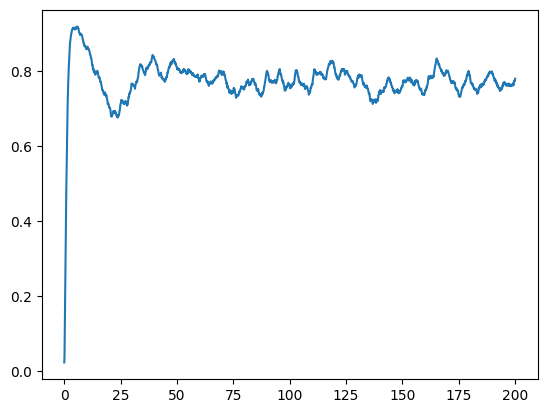

In [415]:
plt.plot(t,r)

In [955]:
ro_count

array([[ 0., -1.,  0., ..., -1.,  0., -1.],
       [ 0., -1.,  0., ..., -1.,  0., -1.],
       [ 0., -1.,  0., ..., -1.,  0., -1.],
       ...,
       [ 0.,  3.,  0., ..., 20., 20., 17.],
       [ 0.,  3.,  0., ..., 20., 20., 17.],
       [ 0.,  3.,  0., ..., 20., 20., 17.]])

In [956]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 0.9
Ds =np.linspace(0.4,0.6,20)
chis = []
d_rsigma = []
for D in tqdm(Ds):
    # sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
    # sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
    # sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
    sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))

    # sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
    th = 0
    theta_s = sol[th:,:N]
    rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
    # rabs = rabs_[len(t)//2:]
    r = np.abs(rabs)
    r_mean = np.mean(r[-len(r)//2:])
    sigma_phi = np.mean(rabs[-len(r)//2:])
    sigma = np.abs(sigma_phi)
    psi = np.abs(sigma_phi)
    chi = np.mean(np.abs(rabs-sigma_phi)**2)*N
    chis.append(chi)
    d_rsigma.append(np.abs(r_mean-sigma))

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

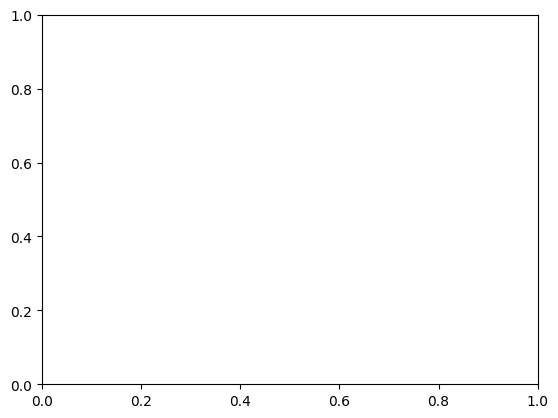

In [1002]:
plt.plot(Ds,chis,color='red')
plt.twinx()
plt.plot(Ds,d_rsigma)

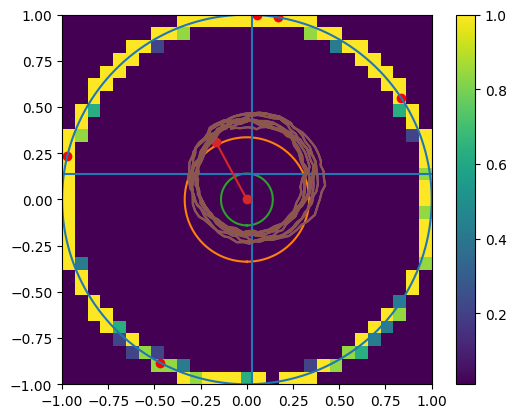

In [429]:
exps =np.exp(1j*theta_s)

idx = 110
plt.figure()
ax = plt.gca()
fig = plt.gcf()


# hist_2d = ax.hist2d(np.real(exps[idx]),np.imag(exps[idx]),bins=[real,real],norm='log',density=True,vmax=1,vmin=1e-2)
hist_2d = ax.hist2d(np.real(exps[idx]),np.imag(exps[idx]),bins=[real,real],norm='linear',density=True,vmax=1,vmin=1e-2)
ax.scatter(np.real(exps[idx,Arg_Deg[:5]]),np.imag(exps[idx,Arg_Deg[:5]]),color='red')
plt.gca().set_aspect('1')
plt.colorbar(hist_2d[-1])

c_ = np.linspace(-np.pi,np.pi,10000)
ax.plot(np.sin(c_),np.cos(c_))
ax.plot(r_mean*np.sin(c_),r_mean*np.cos(c_))
ax.plot(sigma*np.sin(c_),sigma*np.cos(c_))
ax.axvline(np.real(sigma_phi))
ax.axhline(np.imag(sigma_phi))

ax.plot([0,np.real(rabs)[idx]],[0,np.imag(rabs)[idx]],'o-')
# ax.axvline(np.real(rabs)[-idx],color='red')
# ax.axhline(np.imag(rabs)[-idx],color='red')
ax.plot(np.real(rabs)[-500:],np.imag(rabs)[-500:])
ax.plot(np.real(rabs)[-500:],np.imag(rabs)[-500:])
# plt.scatter(np.real(exps[-1]),np.imag(exps[-1]));
# np.histogram2d()

In [964]:
### ANIMATAION 관련 ###
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
from matplotlib.colors import Normalize
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [915]:
def animation(idx):
    # data_n = np.sin(sol[idx].reshape((N,N)))
    ax.clear()
    hist_2d = ax.hist2d(np.real(exps[idx]),np.imag(exps[idx]),bins=[real,real],norm='log',density=True,vmax=1,vmin=1e-2)
    ax.scatter(np.real(exps[idx,Arg_Deg[:5]]),np.imag(exps[idx,Arg_Deg[:5]]),color='red')
    ax.scatter(np.real(exps[idx,Arg_Deg[-5:]]),np.imag(exps[idx,Arg_Deg[-5:]]),color='blue')
    ax.plot([0,np.real(rabs)[idx]],[0,np.imag(rabs)[idx]],'o-')
idxs=  np.arange(0,len(t)//5,1)

In [916]:

ani = FuncAnimation(fig,animation,frames=idxs,interval=50)
# 확인용
HTML(ani.to_html5_video())

In [1183]:
th = 0# len(t)//2

theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1173]:
np.mean(r[len(t)//2:])-sigma

0.06117232361931235

In [1118]:
A.shape

(1000, 1000)

In [1119]:
Aij = nx.adjacency_matrix(G)
Deg = Aij.sum(axis=1)
mk = Deg.mean()
mk

3.992

In [1120]:
rabsN = 1/(N*MD) * np.sum(Deg.reshape(-1,1)*np.exp(theta_s.T*1j) ,axis=0)
rN = np.abs(rabsN)
sigma_phi = np.mean(rabsN)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1022]:
np.mean(rN) - sigma

2.456063895028837e-05

(array([ 28.,  11.,   9.,  17.,  72., 196., 368., 625., 489., 186.]),
 array([-3.12446321, -2.49816873, -1.87187425, -1.24557977, -0.61928529,
         0.00700919,  0.63330367,  1.25959815,  1.88589263,  2.51218711,
         3.13848159]),
 <BarContainer object of 10 artists>)

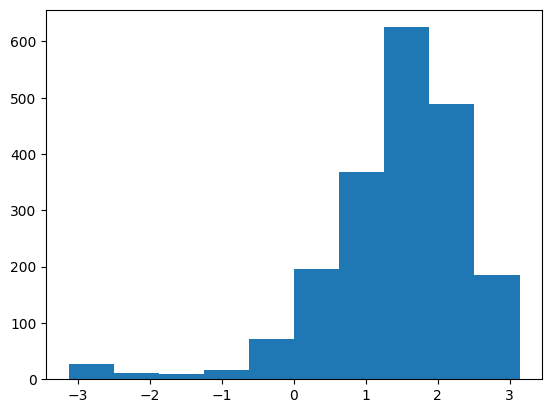

In [430]:
dtheta = (sol[-1] - sol[len(sol)//2])/(t[-1]-t[len(sol)//2])



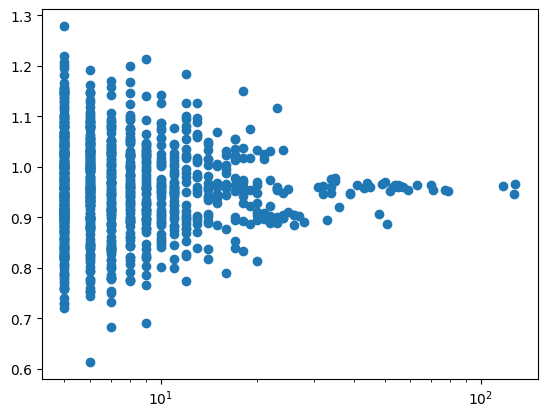

In [434]:
plt.scatter(Deg,dtheta)
plt.xscale('log')

(array([ 1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  4.,  2.,  9.,  5., 15.,
         9., 10., 28., 21., 31., 15., 26., 45., 63., 52., 45., 46., 82.,
        76., 40., 39., 49., 54., 45., 36., 30., 24., 28., 16.,  7.,  9.,
        10., 12.,  4.,  2.,  2.,  3.,  2.,  0.,  0.,  0.,  1.]),
 array([0.61394037, 0.6272412 , 0.64054202, 0.65384285, 0.66714367,
        0.6804445 , 0.69374532, 0.70704615, 0.72034697, 0.7336478 ,
        0.74694862, 0.76024945, 0.77355027, 0.7868511 , 0.80015192,
        0.81345275, 0.82675358, 0.8400544 , 0.85335523, 0.86665605,
        0.87995688, 0.8932577 , 0.90655853, 0.91985935, 0.93316018,
        0.946461  , 0.95976183, 0.97306265, 0.98636348, 0.9996643 ,
        1.01296513, 1.02626595, 1.03956678, 1.05286761, 1.06616843,
        1.07946926, 1.09277008, 1.10607091, 1.11937173, 1.13267256,
        1.14597338, 1.15927421, 1.17257503, 1.18587586, 1.19917668,
        1.21247751, 1.22577833, 1.23907916, 1.25237998, 1.26568081,
        1.27898164]),
 <BarContainer

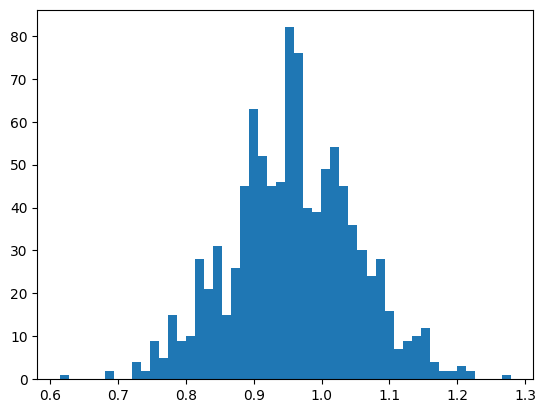

In [438]:
plt.hist(dtheta,bins=50)

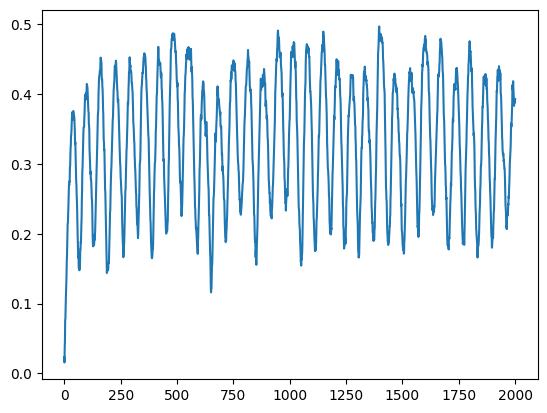

In [433]:
# plt.plot(rN)
plt.plot(r)
# plt.plot(r2)

In [982]:
reduced = (sol%(np.pi*2))
mean_residue = np.mean(reduced,axis=1)
std_residue = np.std(reduced,axis=1)

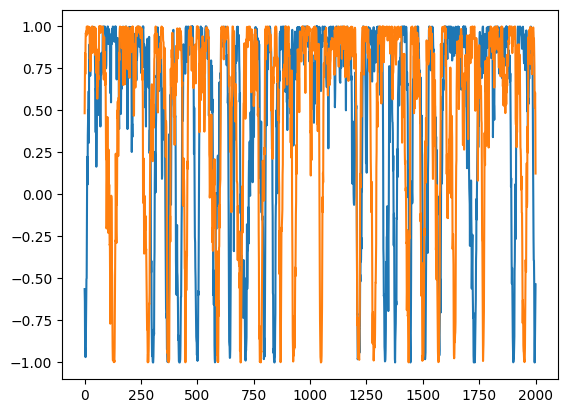

In [983]:
plt.plot(np.sin(sol[:,Arg_Deg[0]]))
plt.plot(np.sin(sol[:,Arg_Deg[N//2]]))

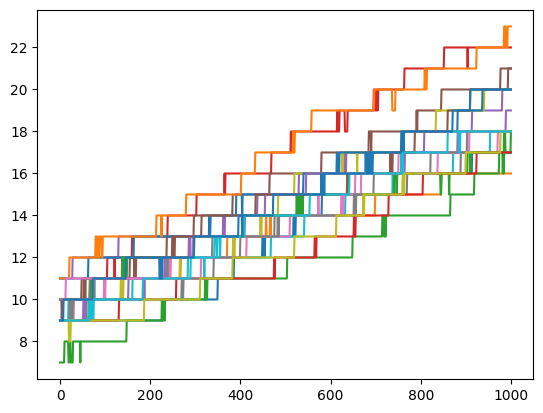

In [986]:
plt.plot(sol[len(sol)//2:,Arg_Deg[0]]//(np.pi*2))
plt.plot(sol[len(sol)//2:,Arg_Deg[100:120]]//(np.pi*2))
# plt.plot(sol[:,Arg_Deg[100]]//(np.pi*2))

In [1085]:
A = (sol+np.pi)%(2*np.pi) - np.pi

In [1005]:
A[:,0].shape

(2001,)

In [1007]:
Deg[-50:]

array([10, 10, 10, 10, 10, 10, 11, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

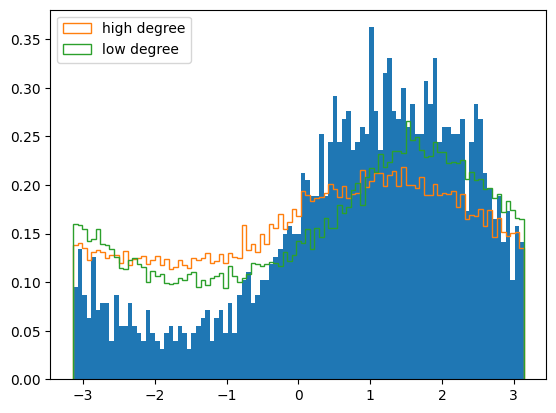

In [1094]:
A = (sol+np.pi)%(2*np.pi) - np.pi
bins = np.linspace(-np.pi,np.pi,100)

# plt.axes(polar=True)
plt.hist(np.angle(rabs[:]),bins=bins,density=True)
plt.hist(A[len(sol)//2:,Arg_Deg[:50]].flatten(),bins=bins, histtype='step', stacked=True, fill=False,label='high degree',density=True)
plt.hist(A[len(sol)//2:,Arg_Deg[-50:]].flatten(),bins=bins, histtype='step', stacked=True, fill=False,label='low degree',density=True)
plt.legend()

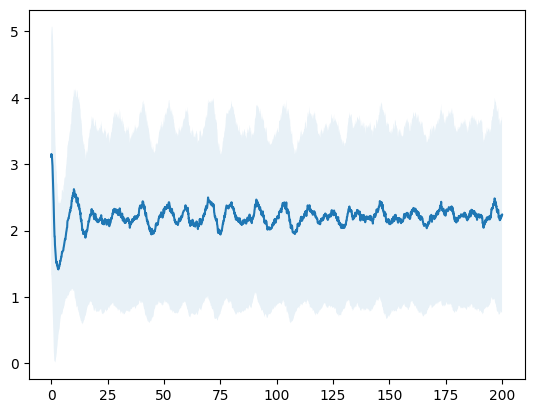

In [1009]:
plt.plot(t,mean_residue)
plt.fill_between(t,mean_residue-std_residue,mean_residue+std_residue,alpha=0.1)

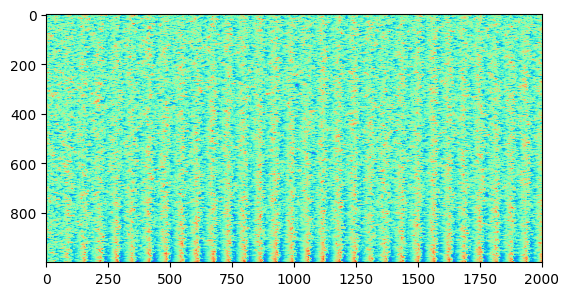

In [1011]:
plt.imshow((sol[:,Arg_Deg]%(2*np.pi)).T[-3000:],cmap='rainbow')

In [1088]:
h,b_ = np.histogram(np.linspace(-np.pi,np.pi),bins=200)
# h,b_ = np.histogram(A[len(t)//2,:],bins=100)
A = (theta_s+np.pi)%(2*np.pi)-np.pi
hs = []
for i in range(500):
    h,_ = np.histogram(A[i,:],bins=b_)
    hs.append(h)
hs = np.array(hs)
# b_theta = np.arcsin(b_)



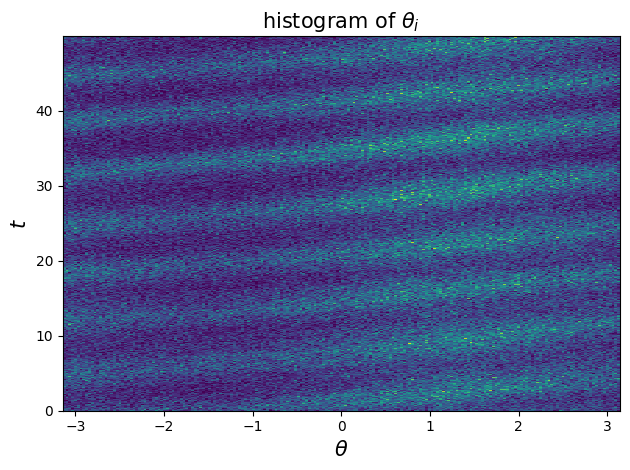

In [1089]:
b_theta = b_
plt.pcolormesh(b_theta,t[:500],hs[1:500])
plt.gca().set_aspect('auto')
plt.ylabel(r'$t$',fontsize=15)
plt.xlabel(r'$\theta$',fontsize=15)
plt.title(r'histogram of $\theta_i$',fontsize=15)
plt.xlim(-np.pi,np.pi)
plt.tight_layout()

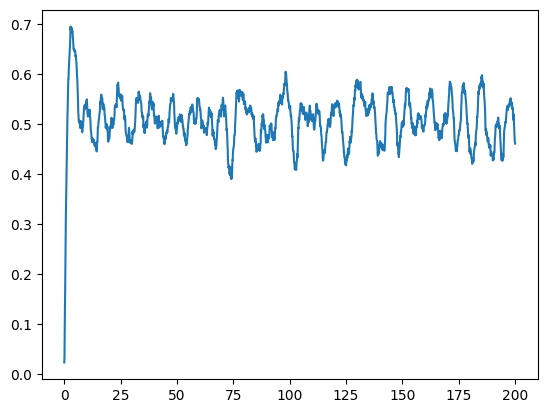

In [845]:
t_ = t[th:] 
plt.plot(t_,r)

In [939]:
db = 0.02
Ds = np.arange(0,2+db/2,db)
bs = np.arange(0,2+db/2,db)
len(Ds)
# Ds = np.linspace(0,2,10)
# bs = np.linspace(0,2,11)

101

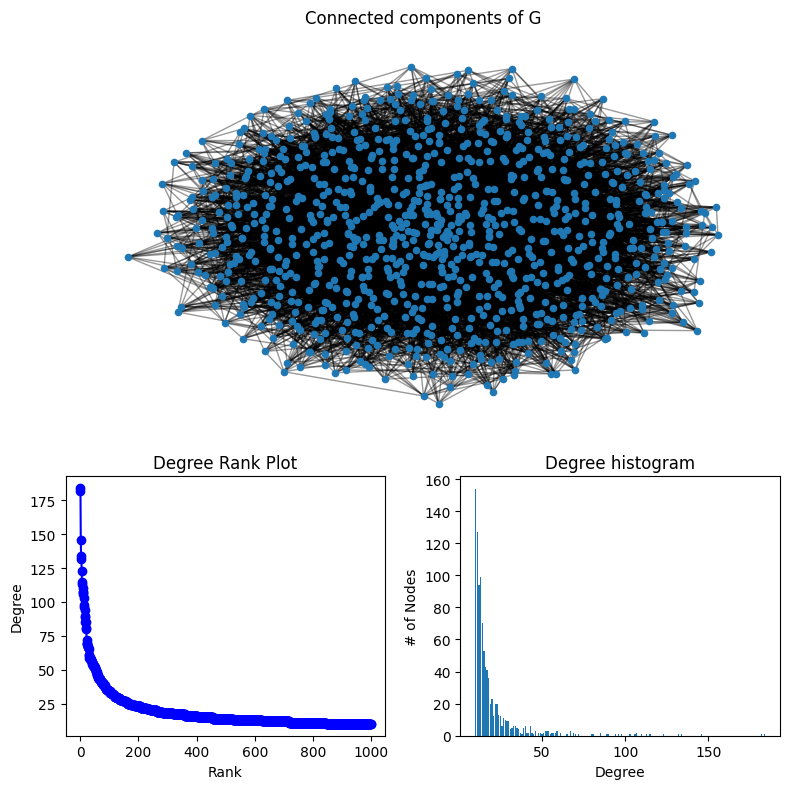

In [748]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# G = nx.gnp_random_graph(N, p, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [749]:
Deg = np.sum(Aij,axis=1)
Arg_Deg = np.argsort(Deg)

[]

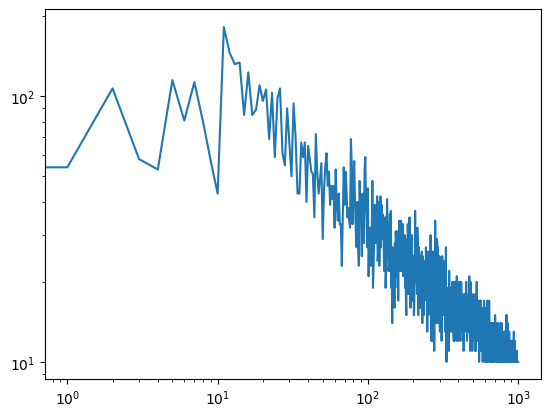

In [750]:
plt.plot(Deg)
plt.loglog()

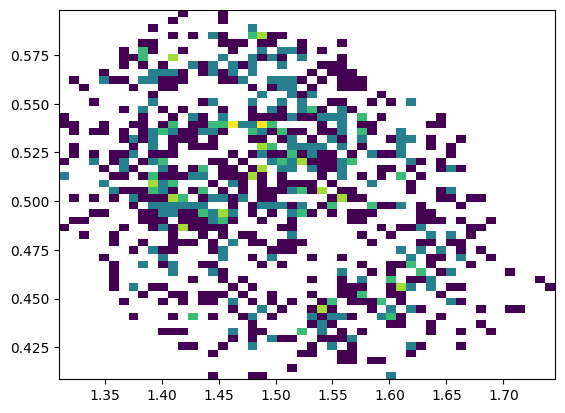

In [846]:
plt.hist2d(np.angle(rabs)[1000:],np.abs(rabs)[1000:],bins=[50,50],density=True,norm='log');
# plt.colorbar()

In [853]:
Arg_Deg

array([999, 880, 879, 877, 873, 871, 644, 868, 625, 867, 647, 864, 862,
       651, 652, 859, 663, 866, 855, 882, 884, 912, 910, 909, 908, 907,
       905, 902, 623, 599, 607, 891, 889, 780, 887, 886, 885, 896, 854,
       853, 670, 751, 803, 754, 800, 759, 760, 797, 748, 761, 762, 793,
       792, 790, 785, 776, 781, 795, 807, 747, 738, 848, 333, 845, 680,
       688, 839, 838, 836, 833, 706, 715, 827, 820, 819, 818, 728, 734,
       580, 917, 888, 919, 971, 970, 969, 968, 967, 966, 965, 964, 963,
       962, 961, 918, 960, 959, 957, 955, 954, 953, 952, 951, 950, 972,
       948, 973, 976, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988,
       987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 549, 974, 947,
       778, 925, 923, 924, 939, 938, 937, 936, 941, 926, 927, 928, 998,
       931, 946, 929, 935, 942, 930, 944, 921, 943, 920, 945, 604, 777,
       605, 743, 606, 602, 737, 735, 494, 730, 739, 750, 575, 479, 774,
       595, 757, 593, 773, 586, 770, 729, 768, 766, 480, 765, 57

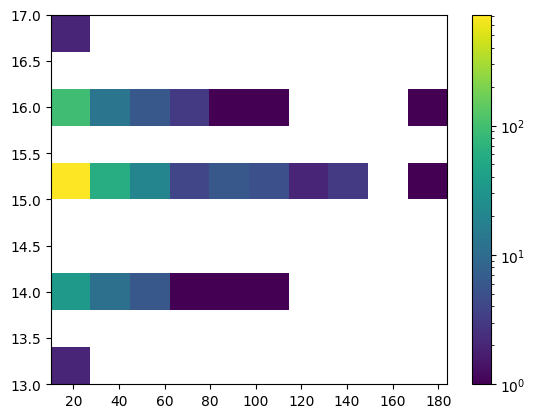

In [870]:
plt.hist2d(Deg,ro_count[-1,Arg_Deg],norm='log')
plt.colorbar()

In [941]:
t.shape

(4001,)

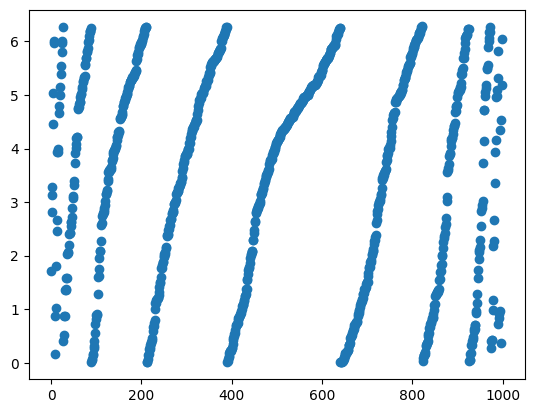

In [824]:
plt.scatter(np.arange(N),np.sort(theta_s[-400])%(np.pi*2))

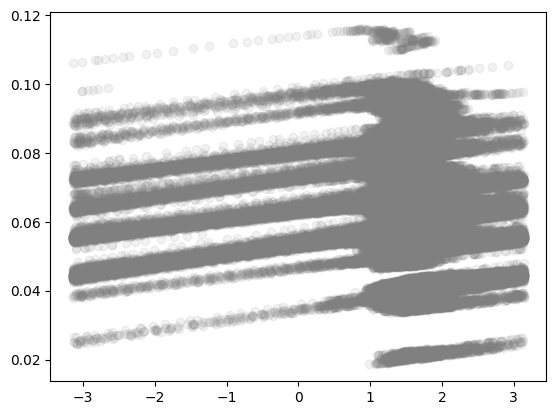

In [1101]:
idx = -10
A = (theta_s+np.pi)%(2*np.pi)-np.pi

for idx in range(-1000,-1):
    vtheta_s = (theta_s[idx] - theta_s[0]) /(t[idx]-t[0])
    plt.scatter(A[idx],vtheta_s,color='gray',alpha=0.1)

In [1150]:
sum_time =  100
theta_c = np.cumsum(theta_s[:], axis=0)
avg_theta = (theta_c[sum_time:]-theta_c[:-sum_time])/sum_time

In [1151]:
avg_dtheta_s = np.diff(avg_theta/dt,axis=0)

In [1152]:
A = (theta_s+np.pi)%(2*np.pi)-np.pi

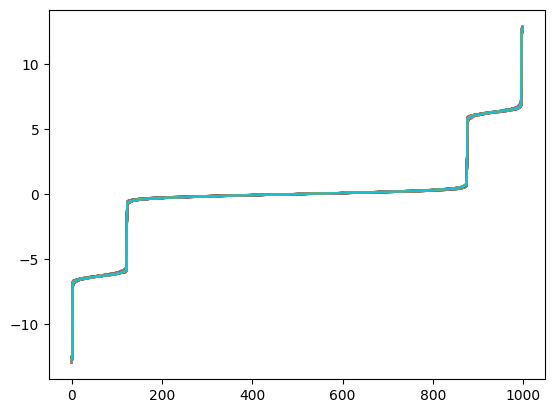

In [1172]:
plt.plot(np.sort(avg_dtheta[-100:].T,axis=0))

In [1168]:
# for i in range(-200,-1):
for i in range(1000):
    plt.scatter(A[-600-sum_time:-sum_time,i],avg_dtheta_s[-600:,i],alpha=0.3)
plt.axvline(np.pi/2)
plt.axvline(np.pi)
plt.axvline(-np.pi)
plt.axvline(-np.pi/2)

NotImplementedError: We have not yet implemented 1D sparse slices; please index using explicit indices, e.g. `x[:, [0]]`

In [900]:
avg_theta.T[1].shape

(3901,)

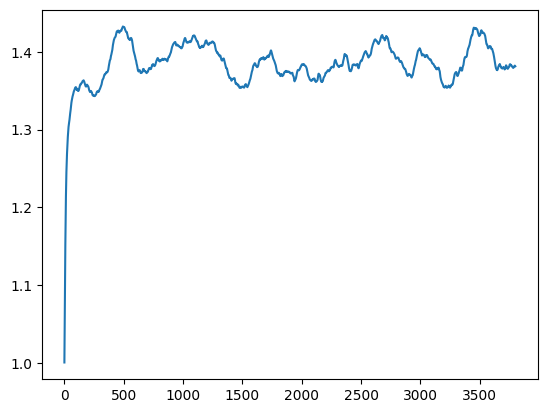

In [905]:
plt.plot(avg_theta.T[1])
# plt.plot(theta_s.T[1])

In [797]:
# np.cumsum(theta_s[:], axis=0)

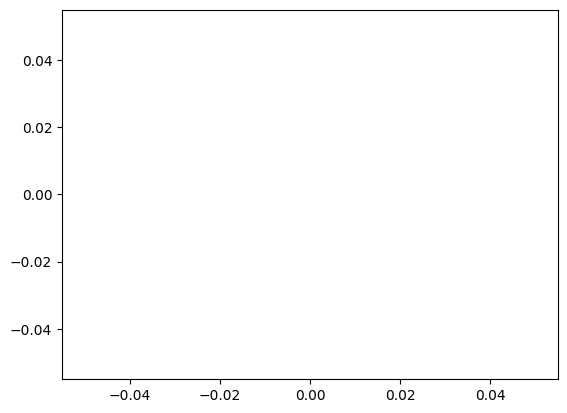

In [951]:
plt.scatter(dtheta_s[-1]2)

In [868]:
ti_arg = np.argsort(theta_s[-1])

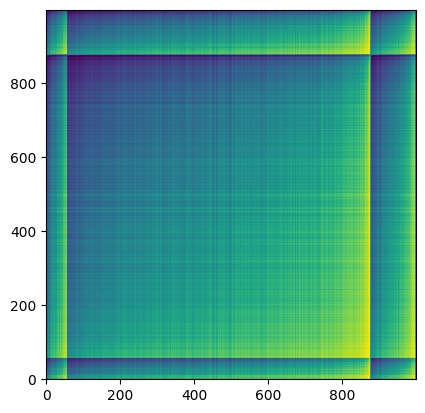

In [869]:
ti = theta_s[1999][ti_arg]
# ti = np.sort(ti)
# ti_arg = np.argsort(ti)
i,j = np.meshgrid(ti,ti)
plt.imshow(np.sin(i-j),origin='lower')

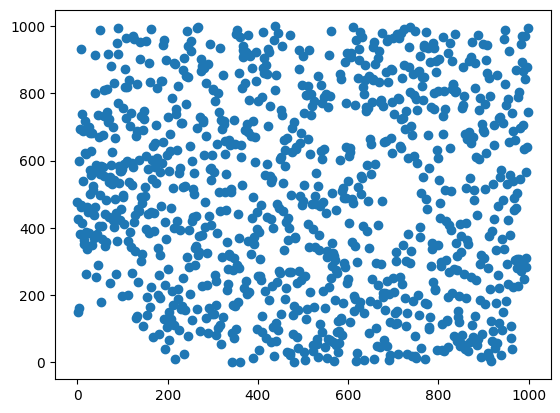

In [798]:
plt.scatter(ti_arg,Arg_Deg)

In [955]:
G.mean()

AttributeError: 'Graph' object has no attribute 'mean'

In [285]:
mk = 5
N = 1000
p = mk/(N)
G = nx.erdos_renyi_graph(N,p)
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
MD = Deg.mean()

In [1059]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.51
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))

In [1187]:
db = 0.1
Ds = np.arange(0,1.5+db/2,db)
bs = np.arange(0,1.5+db/2,db)
len(Ds)

16

In [1189]:
th = len(t)//2

In [1190]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for b in bs:        
        sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))
        theta_s = sol[th:,:N]
        dtheta_s = sol[th:,N:2*N] 
        rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
        # rabs = rabs_[len(t)//2:]
        r = np.abs(rabs)
        sigma_phi = np.mean(rabs)
        sigma = np.abs(sigma_phi)
        psi = np.abs(sigma_phi)
        sigma,np.mean(r)
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/16 [00:00<?, ?it/s]

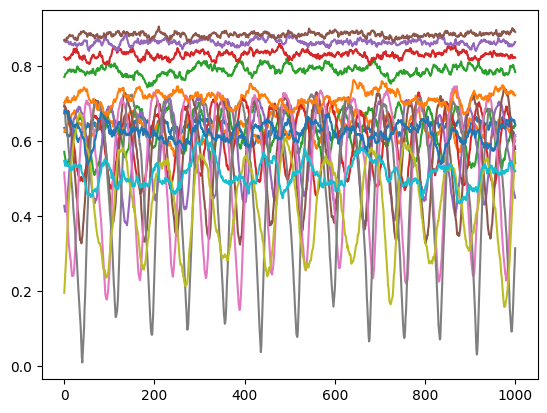

In [1210]:
plt.plot(D_rij[8].T)

In [1191]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)
D_r_meanij = np.mean(D_rij,axis=2)

In [1193]:
np.savez(f'm = {10} mk = {mk} db={db} SF',Ds=Ds,bs=bs,D_mrij=D_r_meanij,D_sij = D_sigmaij,G = G)

In [1194]:
DD,BB = np.meshgrid(Ds,bs)

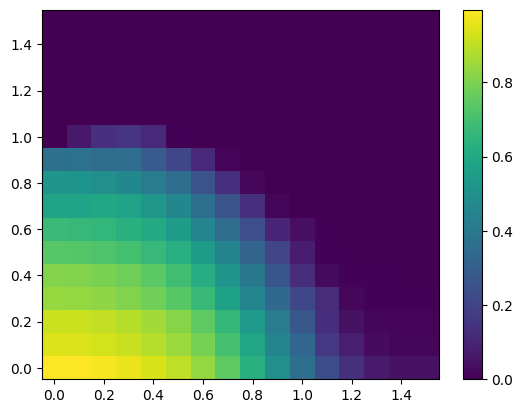

In [1211]:
Z = np.abs(D_sigmaij-D_r_meanij).T
# CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

CS  = plt.pcolormesh(Ds,bs,abs(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


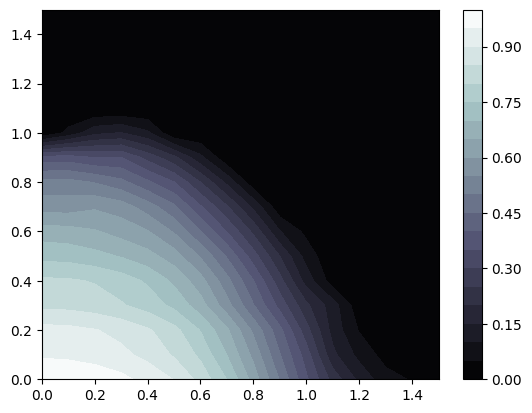

In [1196]:
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

# CS  = plt.pcolormesh(Ds,bs,(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


In [1]:
fig,(ax1,ax2) = plt.subplots(1,2,width_ratios=[1,1],dpi=400)
plt.sca(ax1)
b_idx = 10
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,50, cmap=plt.cm.bone)

CS2 = plt.contour(CS, levels=CS.levels[3:5],linewidths=0.5, colors='r')
cbar = plt.colorbar(CS,shrink=0.4)
plt.gca().set_aspect('1')
cbar.add_lines(CS2)
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$b$',fontsize=15)
plt.title(r'$r-\sigma$',fontsize=15)

plt.axhline(bs[b_idx],color='red',lw=0.5,ls='--')

plt.sca(ax2)

plt.plot(Ds,D_r_meanij[:,b_idx],'.-',color='red',label =r'$r$')
plt.plot(Ds,D_sigmaij[:,b_idx],'.-',color='gray',label =r'$\sigma$')
plt.gca().set_aspect('1.9')

plt.legend()
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title(f'b = {bs[b_idx]}',fontsize=15)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined